In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from IPython.display import display
from sklearn import metrics

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## read training data

In [3]:
path ="/home/ubuntu/bluebook-for-bulldozers/"

In [4]:
df_raw = pd.read_csv(f'{path}Train.csv', low_memory=False, parse_dates=["saledate"])

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [6]:
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


## evaluation criterion was root mean squared log error

#### transform target using log

In [11]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

### feature engineering on the date column

In [8]:
add_datepart(df_raw, 'saledate')

### changing data type of the string columns to category

In [9]:
train_cats(df_raw)

In [10]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered = True, inplace = True)

### checking for % of missing values in each column

In [14]:
display_all(df_raw.isnull().sum().sort_values(ascending = False)/len(df_raw))

Pushblock                   0.937129
Blade_Extension             0.937129
Blade_Width                 0.937129
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Tip_Control                 0.937129
Scarifier                   0.937102
Grouser_Tracks              0.891899
Hydraulics_Flow             0.891899
Coupler_System              0.891660
fiModelSeries               0.858129
Steering_Controls           0.827064
Differential_Type           0.826959
UsageBand                   0.826391
fiModelDescriptor           0.820707
Backhoe_Mounting            0.803872
Pad_Type                    0.802720
Stick                       0.802720
Turbocharged                0.802720
Blade_Type                  0.800977
Travel_Controls             0.800975
Tire_Size                   0.763869
Track_Type                  0.752813
Grouser_Type                0.752813
Stick_Length                0.752651
Pattern_Changer             0.752651
Thumb                       0.752476
U

### saving the changes made in a feather format

In [15]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/raw')

### can directly use the previously made feather file and you will see that all the changes made are still there

In [16]:
df_raw = pd.read_feather('tmp/raw')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:742: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


## proc_df takes a data frame df and splits off the response variable, and changes the df into an entirely numeric dataframe

### imputing missing numeric values with the median of the column
### replacing values in the category column with an unique number for each level of the categorical variable

In [18]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [19]:
display_all(df.head())

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,2,950,296,41,0,0,0,59,1,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2006,11,46,16,3,320,False,False,False,False,False,False,1163635200,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,2,1725,527,55,98,0,4,62,33,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2004,3,13,26,4,86,False,False,False,False,False,False,1080259200,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,331,110,0,0,0,0,39,32,3,3,0,6,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,2004,2,9,26,3,57,False,False,False,False,False,False,1077753600,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3674,1375,0,45,0,6,8,44,4,4,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,5,20,19,3,139,False,False,False,False,False,False,1305763200,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,3,4208,1529,0,0,0,0,40,32,3,3,0,1,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,2009,7,30,23,3,204,False,False,False,False,False,False,1248307200,False,False


### building a basic random forest model to predict sale price

In [20]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y) # train R^2 values

0.9824847545836162

In [21]:
metrics.mean_squared_error(y, m.predict(df)) # train mse value

8.241519514007675e-05

In [22]:
np.sqrt(metrics.mean_squared_error(y, m.predict(df))) # train rmse value

0.009078281508087128

### reading test data

In [23]:
df_test = pd.read_csv(f'{path}Valid.csv', low_memory=False, parse_dates=["saledate"])

In [24]:
df_test.shape

(11573, 52)

In [26]:
df_raw.shape

(401125, 65)

### if the test data set contains data points in the future, then split train data set such that the validation data set contains the latest data points becoz here assumption is that data points are more related to t-1, t-2, etc data points 

In [27]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

### took a sample of 12000 data points from the train data set and assigned them to a validation data set to match the total data points in the test data set

In [28]:
n_valid = 12000
n_trn = len(df) - n_valid

In [29]:
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((389125, 66), (12000, 66), (389125,), (12000,))

### defined a function to calculate rmse, r^2, oob_score values for the train and validation data set

In [30]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid), 
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [31]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 23s, sys: 196 ms, total: 1min 23s
Wall time: 25.1 s
[0.00906990166425411, 0.025176354526142995, 0.9824156185351363, 0.8850930030294002]


### extra for practice - start

In [37]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [38]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 3.56 s, sys: 4 ms, total: 3.56 s
Wall time: 1.09 s
[0.1150135916610573, 0.3812397679756756, 0.9706086457002446, 0.7404360544507093]


In [40]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 180 ms
[0.5204898615126017, 0.5812518035347155, 0.39807024094307275, 0.3966398807662924]


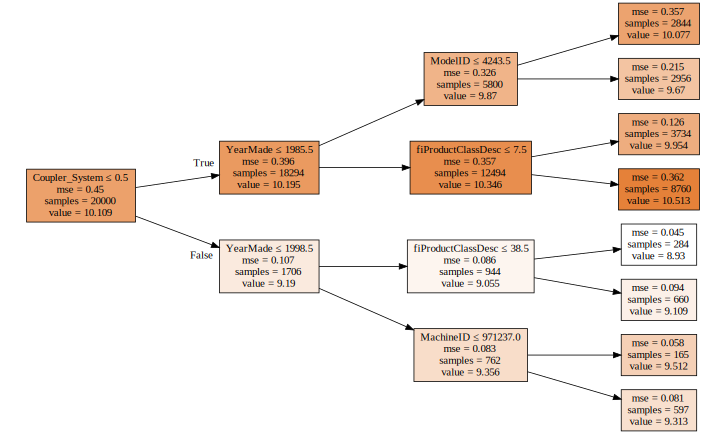

In [48]:
draw_tree(m.estimators_[0], df_trn, precision=3)

### extra for practice - end

### explained the concept of bagging - looked at the predictions from each tree in RF and then took mean of it to get the final result

In [32]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

In [33]:
preds[:,0]

array([2.20882, 2.22033, 2.20882, 2.19989, 2.20882, 2.20882, 2.20882, 2.19922, 2.23993, 2.20882])

In [34]:
np.mean(preds[:,0])

2.2112292525274913

In [35]:
y_valid[0]

2.2088215008013257

## understanding how r^2 value flattens out after certain number of estimators

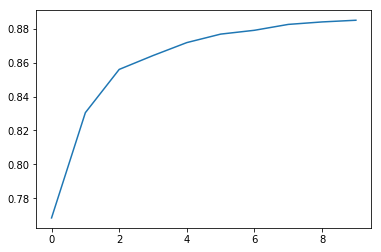

In [36]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)])

### tried multiple models with hyperparameter tuning

In [37]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.008276509330810802, 0.025304188751720098, 0.9853574620742211, 0.8839231482635853]


In [38]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 55s, sys: 408 ms, total: 5min 55s
Wall time: 1min 30s
[0.007858780875706198, 0.024313930287452785, 0.98679822584865, 0.8928305213580664]


### will look at the oob score as well

In [39]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 57s, sys: 756 ms, total: 5min 58s
Wall time: 1min 34s
[0.007867552914345053, 0.024253305218712443, 0.9867687375331263, 0.8933642941238551, 0.9056704446161528]


### From above results, I can say that the model is overfitting the training data as it's error is far less than the validation error
### In training RF model, using total data points 389,125 did not improve the validation r^2 or error, so instead of using all the data points with bootstrap, not will feed 20,000 random data points to each estimator of RF model

In [45]:
set_rf_samples(20000)

In [41]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.023931260378317956, 0.028021470239623418, 0.8775798002965788, 0.8576548677842485, 0.8647406249952991]


In [42]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 32.9 s, sys: 996 ms, total: 33.9 s
Wall time: 14 s
[0.02264144493045085, 0.026226037355260395, 0.8904202720421855, 0.8753115763260153, 0.8787423594289462]


In [46]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 27.6 s, sys: 984 ms, total: 28.6 s
Wall time: 12.4 s
[0.02310871782757223, 0.02636960354166829, 0.8858505985048931, 0.8739427047697537, 0.8766328045599129]


In [47]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features = 0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 17.6 s, sys: 1.01 s, total: 18.6 s
Wall time: 9.91 s
[0.023314065614425703, 0.026477401232967344, 0.8838128849110125, 0.8729099656671647, 0.8750652097539134]


In [48]:
reset_rf_samples()

In [49]:
set_rf_samples(50000)

In [50]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features = 0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 34.5 s, sys: 932 ms, total: 35.5 s
Wall time: 14.2 s
[0.020625031002700852, 0.02510298913808813, 0.9090691690858929, 0.8857617188570563, 0.891556526153725]


### Along with the predictions, we can also look at its standard deviations for better picture

In [52]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 88 ms, sys: 140 ms, total: 228 ms
Wall time: 1.04 s


(2.221552415807797, 0.026244188315667428)

In [53]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred_mean'] = np.mean(preds, axis=0)

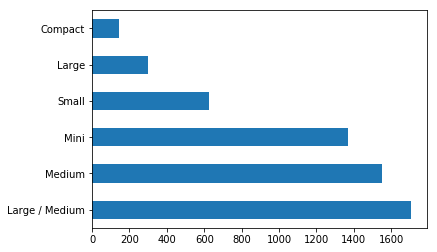

In [54]:
x.ProductSize.value_counts().plot.barh()

In [55]:
flds = ['ProductSize', 'SalePrice', 'pred_mean', 'pred_std']
summ = x[flds].groupby(flds[0], as_index = False).mean()
summ

,ProductSize,SalePrice,pred_mean,pred_std
0,Compact,2.274830,2.287733,0.033196
1,Large,2.346298,2.338830,0.035160
2,Large / Medium,2.368020,2.363620,0.028642
3,Medium,2.366909,2.361357,0.027065
4,Mini,2.254139,2.256163,0.025337
5,Small,2.333077,2.332982,0.030833


In [56]:
(summ.pred_std/summ.pred_mean).sort_values(ascending = False)

1    0.015033
0    0.014511
5    0.013216
2    0.012118
3    0.011462
4    0.011230
dtype: float64

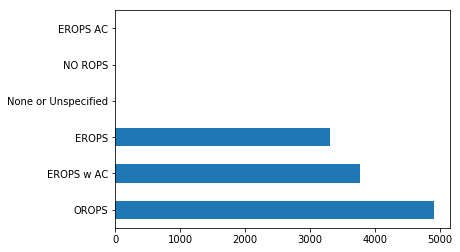

In [57]:
x.Enclosure.value_counts().plot.barh()

In [58]:
flds = ['Enclosure', 'SalePrice', 'pred_mean', 'pred_std']
summ = x[flds].groupby(flds[0], as_index = False).mean()
summ

,Enclosure,SalePrice,pred_mean,pred_std
0,EROPS,2.285296,2.283871,0.027577
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,2.361377,2.357025,0.025385
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,2.268286,2.268876,0.022688


In [59]:
(summ.pred_std/summ.pred_mean).sort_values(ascending = False)

0    0.012074
2    0.010770
5    0.010000
1         NaN
3         NaN
4         NaN
dtype: float64

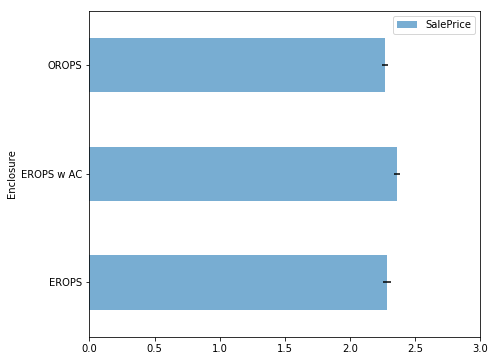

In [61]:
summ = summ[summ.SalePrice.notnull()]
summ.plot('Enclosure', 'SalePrice', 'barh', xerr='pred_std', alpha = 0.6, xlim=(0,3), figsize=(7,6))

## Feature importance

In [63]:
fi = rf_feat_importance(m, df); fi[:10]

,cols,imp
5,YearMade,0.172985
13,ProductSize,0.101579
37,Coupler_System,0.101010
14,fiProductClassDesc,0.079994
39,Hydraulics_Flow,0.059651
2,ModelID,0.057073
63,saleElapsed,0.049420
38,Grouser_Tracks,0.041913
10,fiSecondaryDesc,0.039423
19,Enclosure,0.036949


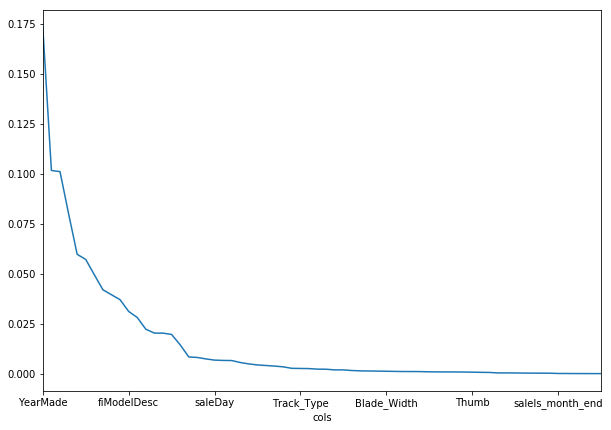

In [64]:
fi.plot('cols', 'imp', legend=False, figsize=(10,7))

In [65]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(16,10), legend=False) 

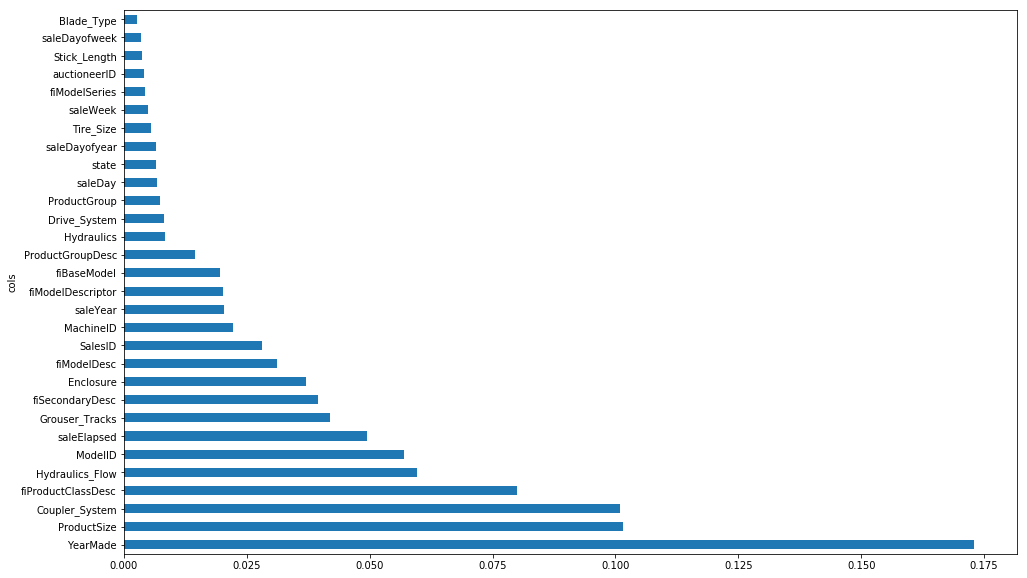

In [66]:
plot_fi(fi[:30])

In [67]:
to_keep = fi[fi.imp > 0.005].cols; len(to_keep)

24

In [69]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [70]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features = 0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 20.8 s, sys: 64 ms, total: 20.9 s
Wall time: 7.29 s
[0.020691608937910645, 0.024731396366958723, 0.9084811691791261, 0.8891187637410867, 0.8916608414877798]


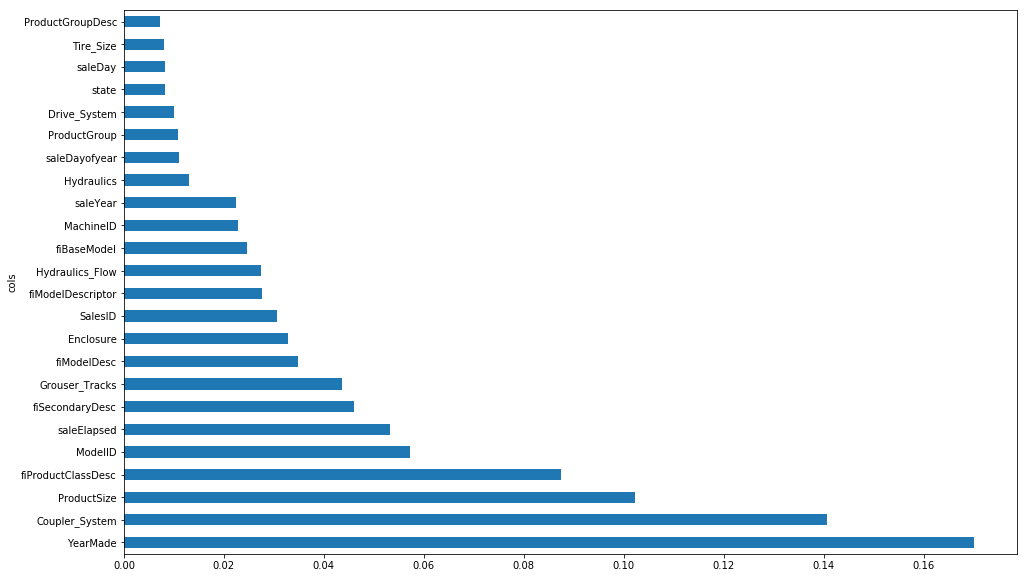

In [71]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi)